In [3]:
from glob import glob
import os
import numpy as np  # 用於數值計算和科學計算
import pandas as pd  # 用於表格型資料的操作
import json  # 用於處理JSON格式的資料
import matplotlib.pyplot as plt  # 用於繪製圖表

import torch
from torch import nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

# Signal labeling

## 🏷️資料標註

我們會使用Label Studio作為資料標註的方式，詳細操作見講義。

############################################################################################

此處待討論是否要先轉csv

############################################################################################

其中有些格式限制，我們的data需轉換為.csv檔並且遵循以下格式:
``` .csv
times, {channel name 1}, {channel name 2}, {channel name 3}
{timepoint1}, {ch1 value0}, {ch2 value0}, {ch3 value0}
{timepoint2}, {ch1 value1}, {ch2 value1}, {ch3 value1}

```
在excel或者Pandas上看就是有time的column以及各個channel的column
- time - 時間點，data type需要是數字，不限浮點數、單位
- channel x - 某個channel的數值, 為浮點數，不限單位

e.g. 
| times | I     | II    | ... |
| ----- | ----- | ----- | --- |
| 0.01  | 0.321 | 0.125 | ... |
| 0.02  | 0.124 | -0.02 | ... |
| 0.03  | 0.124 | -0.21 | ... |
| ...   | ...   | ...   | ... |

In [4]:
data_root = '/home/jovyan/ta-hsi-datacenter3/Medical/CMU_Course_sy/dataset/ECG_segmentation_1DUnet/segments'
datafile = os.path.join(data_root,'2_0.npy')
data = np.load(datafile)
files = glob(data_root+'/*.npy')

In [5]:
df = pd.DataFrame()
df['id'] = list(range(len(files)))
df['filename'] = list(map(lambda x: x.split('/')[-1],files))
df = df.sample(len(df))
L  = int(len(df)*0.8)
df_train = df.iloc[:L]
df_test = df.iloc[L:]

In [6]:
df_train.to_csv(data_root+'/../train_filelist.csv', index=False)
df_test.to_csv(data_root+'/../test_filelist.csv', index=False)

In [7]:
df_train.head()

,id,filename
379,379,7_3.npy
167,167,156_2.npy
714,714,164_4.npy
729,729,50_0.npy
1176,1176,99_7.npy


In [8]:
type(data)

numpy.ndarray

In [9]:
data.shape

(5, 600)

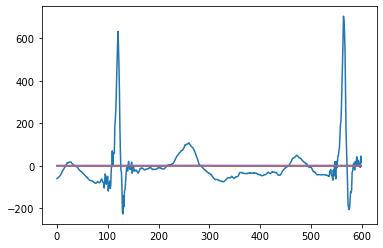

In [10]:
plt.plot(data.T)

# DataLoader

In [11]:
data_root = '/home/jovyan/ta-hsi-datacenter3/Medical/CMU_Course_sy/dataset/ECG_segmentation_1DUnet/segments'
train_file_list = os.path.join(data_root,'..','train_filelist.csv')
test_file_list = os.path.join(data_root,'..','test_filelist.csv')
datafile = os.path.join(data_root,'2_0.npy')
data = np.load(datafile)

In [13]:
class ECGSegmentationDataset(Dataset):
    def __init__(self,
                annotation_file,  # 標註檔案路徑
                data_dir,  # ECG資料路徑
                transform=None,
                channels=None,
                class_names=None, # 資料轉換函式
                dict_format=False):  
        self.signal_paths = data_dir
        self.ecg_signals = pd.read_csv(annotation_file)  # 讀取標註檔案
        self.transform = transform
        self.channels = channels
        self.dict_format = dict_format
        if class_names is not None:
            self.class_map = {n: i for i, n in enumerate(class_names)}
    def __len__(self):
        return len(self.ecg_signals)  # 回傳資料筆數
    def __getitem__(self, idx):
        entry = self.ecg_signals.iloc[idx]  # 取得指定索引的資料
        data = np.load(os.path.join(self.signal_paths, entry['filename']))  # self.signal_paths+entry['filename'])  # 讀取ECG資料
        label = data[1:].argmax(axis=0)  # 取得標籤
        data = data[None,0].astype('float32')
        if self.transform:
            data = self.transform(data)[0]  # 資料轉換
        if self.dict_format:
            return {'x':data, 'labels':label}  # 回傳資料和標籤
        return data, label  # 回傳資料和標籤

In [14]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])

In [15]:
train_ds = ECGSegmentationDataset(train_file_list, data_root,transform=transform, channels=1)
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=4)
val_ds = ECGSegmentationDataset(test_file_list, data_root,transform=transform, channels=1)
val_dl = DataLoader(val_ds, batch_size=64, shuffle=False, num_workers=4)

In [16]:
x, label = next(iter(train_dl))
print('data shape:',x.shape,' dtype:',x.dtype)
print('label shape:',label.shape,' dtype:',label.dtype)

data shape: torch.Size([32, 1, 600])  dtype: torch.float32
label shape: torch.Size([32, 600])  dtype: torch.int64


# Plot DataLoader iter Data

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3538.)
  """Entry point for launching an IPython kernel.


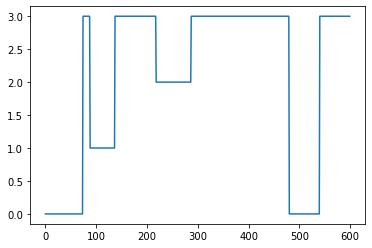

In [17]:
plt.plot(label[0].T)
plt.show()

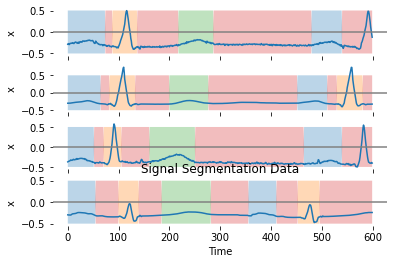

In [18]:
# Get the number of channels and times
num_channels = 4
num_times = x.shape[2]
num_classes = 4

# Create a figure and axes
fig, axes = plt.subplots(nrows=num_channels, ncols=1, sharex=True)
# Set the title
plt.title("Signal Segmentation Data")

dmax = x[:num_channels, 0, :].max()
dmin = x[:num_channels, 0, :].min()
# Plot the data and labels
for i in range(num_channels):
    sig = (x[i, 0, :] - dmin)/dmax - 0.5
    axes[i].plot(np.arange(num_times), sig)
    for j in range(num_classes):
        axes[i].fill_between(np.arange(num_times), (label[i, :] == j) * -0.5, (label[i, :] == j) * 0.5, alpha=0.3)

    # Add horizontal line at y=0
    axes[i].axhline(y=0, color='gray', linestyle='-')

    # Set the x-axis and y-axis labels

    axes[i].set_ylabel("x")
    
    # Remove the frame of each plot
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)
    axes[i].spines['bottom'].set_visible(False)
    axes[i].spines['left'].set_visible(False)
axes[i].set_xlabel("Time")


# Show the plot
plt.show()

# Inspection and plot

In [19]:
train_ds = ECGSegmentationDataset(train_file_list, data_root,transform=transform, channels=1, dict_format=True)
val_ds = ECGSegmentationDataset(test_file_list, data_root,transform=transform, channels=1, dict_format=True)

In [20]:
data = next(iter(val_ds))
print('image shape:',data['x'].shape,' dtype:',data['x'].dtype)
print('label shape:',data['labels'].shape,' dtype:',data['labels'].dtype)

image shape: torch.Size([1, 600])  dtype: torch.float32
label shape: (600,)  dtype: int64


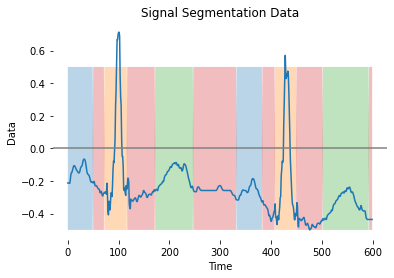

In [21]:
# Get the number of channels and times
num_channels = 1
num_times = data['x'].shape[1]
num_classes = 4

# Create a figure and axes
fig, axes = plt.subplots(nrows=num_channels, ncols=1, sharex=True)
# Set the title
plt.title("Signal Segmentation Data")

dmax = data['x'][:num_channels, :].max()
dmin = data['x'][:num_channels, :].min()
# Plot the data and labels
sig = (data['x'][0, :] - dmin)/dmax - 0.5
axes.plot(np.arange(num_times), sig)
for j in range(num_classes):
    axes.fill_between(np.arange(num_times), (data['labels'] == j) * -0.5, (data['labels'] == j) * 0.5, alpha=0.3)

# Add horizontal line at y=0
axes.axhline(y=0, color='gray', linestyle='-')

# Set the x-axis and y-axis labels

axes.set_ylabel("Data")

# Remove the frame of each plot
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
axes.spines['bottom'].set_visible(False)
axes.spines['left'].set_visible(False)
axes.set_xlabel("Time")


# Show the plot
plt.show()